<a href="https://colab.research.google.com/github/vrossbach/DesafioDS/blob/main/Desafio_DS_VivienRossbach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dentre as habilidades necessárias ao cientista de dados podemos destacar:

●	Conhecimentos sobre estatística.

●	Linguagem Python avançada.

●	Domínio dos processos de Data ETL (Extraction, Transformation, and Loading).

●	Manipulação e organização de dados (Data Wrangling and Data Exploration).

●	Domínio das técnicas de Machine Learning e Deep Learning.

●	Familiaridade com frameworks para processamento com Big Data.

●	Senso crítico para visualização de dados (Data visualization).


# **Parte 1 - Data ETL, Data Wrangling e Data Exploration**

●	Em cada arquivo existe uma coleta de vibração realizada pelo sensor “band-aid”.

●	O nome do arquivo traz as seguintes informações: “{start}-{interval}-{sensor_id}.bin”. 

Exemplo: 1623535615-3006-IAJ9206.csv

■	start: 1623535615 [epoch Unix]

■	interval - sampling duration: 3006 [ms]

■	sensor_id: IAJ9206 [string que identifica um sensor]

●	As coletas dizem respeito aos dados de aceleração em g nos eixos X, Y, Z de um acelerômetro.

Foram realizadas as seguintes etapas:

1.	Apresentação dos dados contidos nos arquivos no domínio do tempo.

2.	Apresentação dos dados contidos nos arquivos no domínio da frequência (fft).

3.	Aplicação de filtros para limpar e corrigir os sinais da melhor forma possível.


Inicialmente foi feita a importação das bibliotecas necessárias para a realização da primeira parte do desafio.

In [ ]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import csv
import sys
from scipy.signal import sosfilt, zpk2sos, iirfilter, sosfreqz
from scipy.fftpack import fft  
import warnings
warnings.filterwarnings("ignore")

Uma biblioteca do Google Colab foi utilizada para que o usuário faça o upload dos arquivos .csv a partir da sua máquina local. Um loop for foi utilizado para que vários arquivos sejam selecionados e importados ao mesmo tempo.

In [ ]:
# Carregar os arquivos a partir da máquina local
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 1623535615-3006-IAJ9206.csv to 1623535615-3006-IAJ9206.csv
Saving 1624040490-2957-NAI1549.csv to 1624040490-2957-NAI1549.csv
Saving 1624374799-3006-MYS2071.csv to 1624374799-3006-MYS2071.csv
Saving 1624962426-3006-NAH4736.csv to 1624962426-3006-NAH4736.csv
User uploaded file "1623535615-3006-IAJ9206.csv" with length 247166 bytes
User uploaded file "1624040490-2957-NAI1549.csv" with length 241490 bytes
User uploaded file "1624374799-3006-MYS2071.csv" with length 246038 bytes
User uploaded file "1624962426-3006-NAH4736.csv" with length 243077 bytes


Os nomes dos arquivos são importantes porque deles são extraídas informações como o intervalo de tempo de cada medição e o id do sensor. A seguir utilizou-se uma função para listar os nomes dos arquivos. Os nomes foram transformados em um dataframe e separados para obter as informações necessárias.

In [ ]:
# A partir dos nomes dos arquivos serão extraídas informações para criação de séries temporais
lista_nomes = []
for fn in uploaded.keys():
  nome = os.path.basename(fn)
  lista_nomes.append(nome)

In [ ]:
df_nomes = pd.DataFrame(np.array(lista_nomes).reshape(4,1))
df_nomes

,0
0,1623535615-3006-IAJ9206.csv
1,1624040490-2957-NAI1549.csv
2,1624374799-3006-MYS2071.csv
3,1624962426-3006-NAH4736.csv


In [ ]:
new = df_nomes[0].astype(str)
new1 = new.str.split("-", n=2, expand=True)
new2 = new1[2].str.split(".", n=2, expand=True)

In [ ]:
df_nomes['start (epoch Unix)'] = new1[0]
df_nomes['interval (ms)'] = new1[1]
df_nomes['sensor_id'] = new2[0]
df_nomes.drop(columns =[0], inplace = True) 
df_nomes

,start (epoch Unix),interval (ms),sensor_id
0,1623535615,3006,IAJ9206
1,1624040490,2957,NAI1549
2,1624374799,3006,MYS2071
3,1624962426,3006,NAH4736


Em seguida os arquivos .csv foram adicionados a uma lista de dataframes (dfs), onde o dataframe correspondente a cada sensor foi identificado com o seu id.

In [ ]:
# Criar uma lista de listas com os arquivos carregados
dfs = []
for fn in uploaded:
    dfs.append(pd.read_csv(fn))

In [ ]:
# Transformar cada lista de dfs em um dataframe
dfIAJ9206 = pd.DataFrame(dfs[0])
dfNAI1549 = pd.DataFrame(dfs[1])
dfMYS2071 = pd.DataFrame(dfs[2])
dfNAH4736 = pd.DataFrame(dfs[3])

**1.   Apresentar os dados contidos nos arquivos no domínio do tempo**

Para criar o eixo temporal dos gráficos, o tempo de funcionamento do sensor (interval) obtido no df_nomes é dividido pelo número total de linhas do dataframe correspondente, o que equivale à taxa de amostragem. Apesar de os tempos de amostragem dos sensores serem diferentes, neste caso o mesmo eixo temporal poderia ser usado para todos, sendo calculado com base em 3006 ms. No entanto, optou-se por calcular o eixo x para cada sensor de modo a evitar erros de aproximação.

In [ ]:
# Obtenção do eixo temporal para cada sensor
interval1 = pd.to_numeric(df_nomes['interval (ms)'][0])
interval2 = pd.to_numeric(df_nomes['interval (ms)'][0])
interval3 = pd.to_numeric(df_nomes['interval (ms)'][0])
interval4 = pd.to_numeric(df_nomes['interval (ms)'][0])
indice1 = pd.to_numeric(dfIAJ9206.index + 1)
indice2 = pd.to_numeric(dfNAI1549.index + 1)
indice3 = pd.to_numeric(dfMYS2071.index + 1)
indice4 = pd.to_numeric(dfNAH4736.index + 1)
tempo_ms1 = (interval1/(indice1)).astype(float)
tempo_ms2 = (interval2/(indice2)).astype(float)
tempo_ms3 = (interval3/(indice3)).astype(float)
tempo_ms4 = (interval4/(indice4)).astype(float)
tempo_ms1 = pd.DataFrame(tempo_ms1.sort_values(ascending=True))
tempo_ms2 = pd.DataFrame(tempo_ms2.sort_values(ascending=True))
tempo_ms3 = pd.DataFrame(tempo_ms3.sort_values(ascending=True))
tempo_ms4 = pd.DataFrame(tempo_ms4.sort_values(ascending=True))

tempo_s1 = tempo_ms1/1000
tempo_s2 = tempo_ms2/1000
tempo_s3 = tempo_ms3/1000
tempo_s4 = tempo_ms4/1000

In [ ]:
dfIAJ9206['tempo_s'] = tempo_s1
dfNAI1549['tempo_s'] = tempo_s2
dfMYS2071['tempo_s'] = tempo_s3
dfNAH4736['tempo_s'] = tempo_s4

A variável tempo é vetorizada para facilitar a realização de operações matemáticas e calcula-se o comprimento de cada vetor de tempo e a frequência correspondente.

In [ ]:
t1 = np.vectorize(float)(tempo_s1)
Ts1 = t1[1]-t1[0]
N1 = len(t1)
Fs1 = 1/Ts1

t2 = np.vectorize(float)(tempo_s2)
Ts2 = t2[1]-t2[0]
N2 = len(t2)
Fs2 = 1/Ts2

t3 = np.vectorize(float)(tempo_s3)
Ts3 = t3[1]-t3[0]
N3 = len(t3)
Fs3 = 1/Ts3

t4 = np.vectorize(float)(tempo_s4)
Ts4 = t4[1]-t4[0]
N4 = len(t4)
Fs4 = 1/Ts4

A figura seguinte mostra a aceleração RMS em x, y e z para os 4 sensores em função do tempo de amostragem.

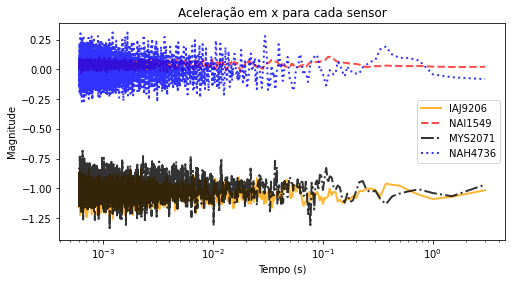

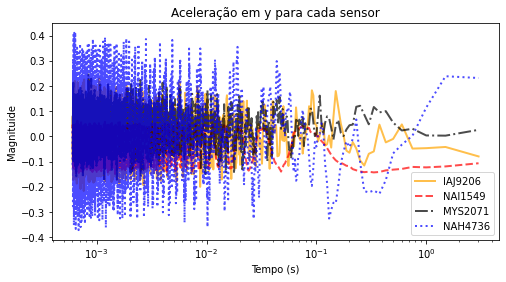

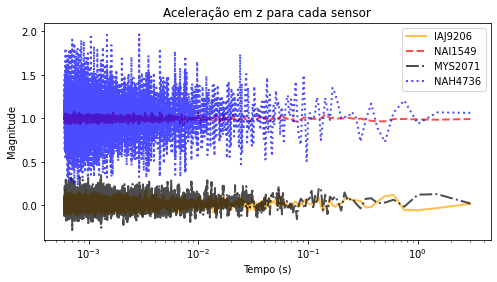

In [ ]:
fig, ax1 = plt.subplots(figsize=[8, 4])
ax1.plot(t1, dfIAJ9206['x'], color = 'orange', linewidth = 2, ls='solid', label= 'IAJ9206', alpha = 0.8)
ax1.plot(t2, dfNAI1549['x'], color = 'red', linewidth = 2, ls='dashed', label= 'NAI1549', alpha = 0.7)
ax1.plot(t3, dfMYS2071['x'], color = 'black', linewidth = 2, ls='dashdot', label= 'MYS2071', alpha = 0.8)
ax1.plot(t4, dfNAH4736['x'], color = 'blue', linewidth = 2, ls='dotted', label= 'NAH4736', alpha = 0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnitude')
plt.title('Aceleração em x para cada sensor')
plt.legend()
plt.xscale('log')

fig, ax2 = plt.subplots(figsize=[8, 4])
ax2.plot(t1, dfIAJ9206['y'], color = 'orange', linewidth = 2, ls='solid', label= 'IAJ9206', alpha = 0.7)
ax2.plot(t2, dfNAI1549['y'], color = 'red', linewidth = 2, ls='dashed', label= 'NAI1549', alpha = 0.7)
ax2.plot(t3, dfMYS2071['y'], color = 'black', linewidth = 2, ls='dashdot', label= 'MYS2071', alpha = 0.7)
ax2.plot(t4, dfNAH4736['y'], color = 'blue', linewidth = 2, ls='dotted', label= 'NAH4736', alpha = 0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnituide')
plt.title('Aceleração em y para cada sensor')
plt.legend()
plt.xscale('log')

fig, ax3 = plt.subplots(figsize=[8, 4])
ax3.plot(t1, dfIAJ9206['z'], color = 'orange', linewidth = 2, ls='solid', label= 'IAJ9206', alpha = 0.7)
ax3.plot(t2, dfNAI1549['z'], color = 'red', linewidth = 2, ls='dashed', label= 'NAI1549', alpha = 0.7)
ax3.plot(t3, dfMYS2071['z'], color = 'black', linewidth = 2, ls='dashdot', label= 'MYS2071', alpha = 0.7)
ax3.plot(t4, dfNAH4736['z'], color = 'blue', linewidth = 2, ls='dotted', label= 'NAH4736', alpha = 0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnitude')
plt.title('Aceleração em z para cada sensor')
plt.legend()
plt.xscale('log')

plt.show()

Nas 3 figuras anteriores, percebe-se que há mais ruído nos sinais do sensor NAH4736 e menos ruído nos sinais do sensor NAI1549. 

**2.   Apresentar os dados contidos nos arquivos no domínio da frequência (fft).**



A figura seguinte mostra a magnitude do sinal de cada sensor em função da sua frequência em Hz. Todos os sinais apresentam um pico superior elevado para a frequência de 0 Hz, que equivale à parte constante do sinal. Também se observam picos em -60 Hz e 60 Hz que são devidos à interferência da rede elétrica.

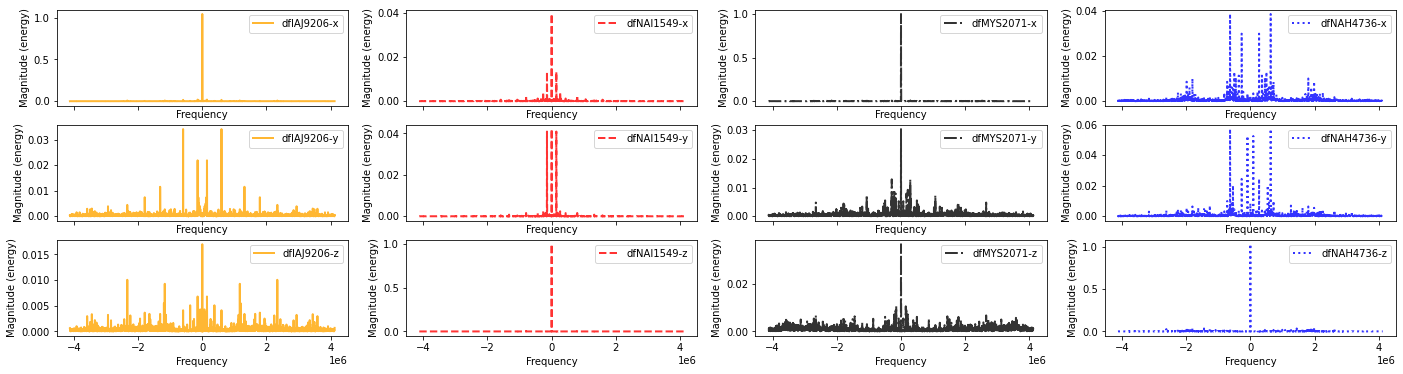

In [ ]:
fig, ax1 = plt.subplots(3,4, figsize=[24, 6], sharex=True)
ax1[0,0].magnitude_spectrum(dfIAJ9206['x'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-x', alpha = 0.8)
ax1[0,1].magnitude_spectrum(dfNAI1549['x'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-x', alpha = 0.8)
ax1[0,2].magnitude_spectrum(dfMYS2071['x'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-x', alpha = 0.8)
ax1[0,3].magnitude_spectrum(dfNAH4736['x'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-x', alpha = 0.8)

ax1[1,0].magnitude_spectrum(dfIAJ9206['y'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-y', alpha = 0.8)
ax1[1,1].magnitude_spectrum(dfNAI1549['y'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-y', alpha = 0.8)
ax1[1,2].magnitude_spectrum(dfMYS2071['y'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-y', alpha = 0.8)
ax1[1,3].magnitude_spectrum(dfNAH4736['y'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-y', alpha = 0.8)

ax1[2,0].magnitude_spectrum(dfIAJ9206['z'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-z', alpha = 0.8)
ax1[2,1].magnitude_spectrum(dfNAI1549['z'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-z', alpha = 0.8)
ax1[2,2].magnitude_spectrum(dfMYS2071['z'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-z', alpha = 0.8)
ax1[2,3].magnitude_spectrum(dfNAH4736['z'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-z', alpha = 0.8)

plt.xlabel('Frequency')
ax1[0,0].legend()
ax1[0,1].legend()
ax1[0,2].legend()
ax1[0,3].legend()
ax1[1,0].legend()
ax1[1,1].legend()
ax1[1,2].legend()
ax1[1,3].legend()
ax1[2,0].legend()
ax1[2,1].legend()
ax1[2,2].legend()
ax1[2,3].legend()
plt.show()

Para melhor visualização, os eixos do gráfico anterior foram colocados em escala log. Assim, na figura abaixo pode-se ver os mesmos sinais de frequência com comportamento ruidoso em frequências superiores a 1e05 Hz.

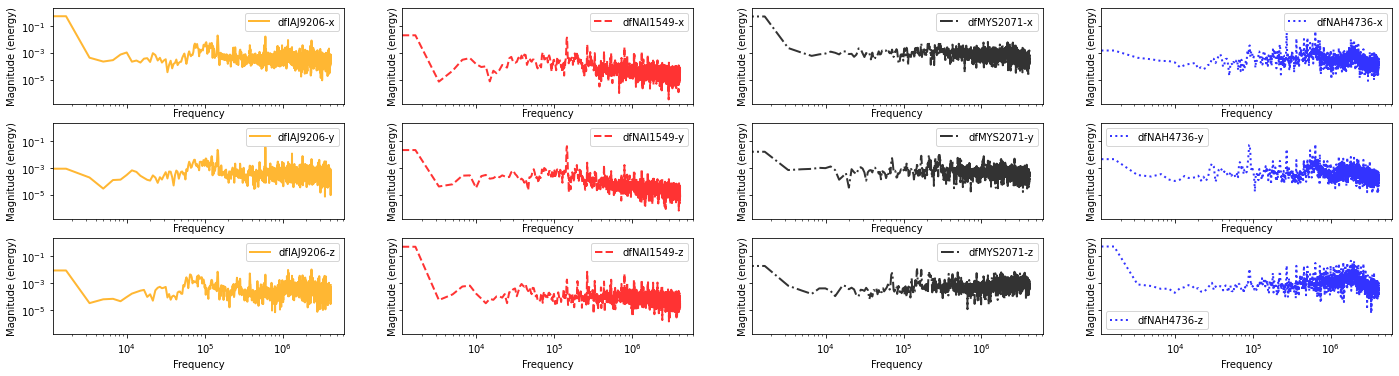

In [ ]:
fig, ax1 = plt.subplots(3,4, figsize=[24, 6], sharex=True, sharey=True)
ax1[0,0].magnitude_spectrum(dfIAJ9206['x'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-x', alpha = 0.8)
ax1[0,1].magnitude_spectrum(dfNAI1549['x'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-x', alpha = 0.8)
ax1[0,2].magnitude_spectrum(dfMYS2071['x'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-x', alpha = 0.8)
ax1[0,3].magnitude_spectrum(dfNAH4736['x'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-x', alpha = 0.8)

ax1[1,0].magnitude_spectrum(dfIAJ9206['y'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-y', alpha = 0.8)
ax1[1,1].magnitude_spectrum(dfNAI1549['y'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-y', alpha = 0.8)
ax1[1,2].magnitude_spectrum(dfMYS2071['y'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-y', alpha = 0.8)
ax1[1,3].magnitude_spectrum(dfNAH4736['y'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-y', alpha = 0.8)

ax1[2,0].magnitude_spectrum(dfIAJ9206['z'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-z', alpha = 0.8)
ax1[2,1].magnitude_spectrum(dfNAI1549['z'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-z', alpha = 0.8)
ax1[2,2].magnitude_spectrum(dfMYS2071['z'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-z', alpha = 0.8)
ax1[2,3].magnitude_spectrum(dfNAH4736['z'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-z', alpha = 0.8)

plt.xlabel('Frequency')
ax1[0,0].legend()
ax1[0,1].legend()
ax1[0,2].legend()
ax1[0,3].legend()
ax1[1,0].legend()
ax1[1,1].legend()
ax1[1,2].legend()
ax1[1,3].legend()
ax1[2,0].legend()
ax1[2,1].legend()
ax1[2,2].legend()
ax1[2,3].legend()
plt.xscale('log')
plt.yscale('log')

plt.show()

Além disso, também são apresentadas na figura abaixo as fases dos sinais de frequência. Os valores negativos são as componentes harmônicas com fase inicial igual a 180°.

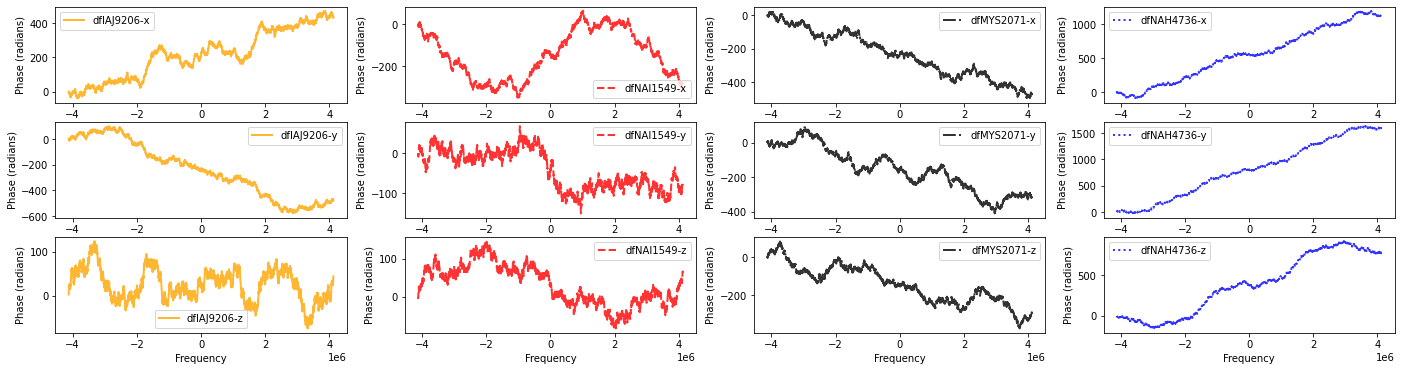

In [ ]:
fig, ax1 = plt.subplots(3,4, figsize=[24, 6])
ax1[0,0].phase_spectrum(dfIAJ9206['x'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-x', alpha = 0.8)
ax1[0,1].phase_spectrum(dfNAI1549['x'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-x', alpha = 0.8)
ax1[0,2].phase_spectrum(dfMYS2071['x'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-x', alpha = 0.8)
ax1[0,3].phase_spectrum(dfNAH4736['x'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-x', alpha = 0.8)

ax1[1,0].phase_spectrum(dfIAJ9206['y'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-y', alpha = 0.8)
ax1[1,1].phase_spectrum(dfNAI1549['y'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-y', alpha = 0.8)
ax1[1,2].phase_spectrum(dfMYS2071['y'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-y', alpha = 0.8)
ax1[1,3].phase_spectrum(dfNAH4736['y'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-y', alpha = 0.8)

ax1[2,0].phase_spectrum(dfIAJ9206['z'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-z', alpha = 0.8)
ax1[2,1].phase_spectrum(dfNAI1549['z'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-z', alpha = 0.8)
ax1[2,2].phase_spectrum(dfMYS2071['z'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-z', alpha = 0.8)
ax1[2,3].phase_spectrum(dfNAH4736['z'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-z', alpha = 0.8)

plt.xlabel('Frequency')
ax1[0,0].legend()
ax1[0,1].legend()
ax1[0,2].legend()
ax1[0,3].legend()
ax1[1,0].legend()
ax1[1,1].legend()
ax1[1,2].legend()
ax1[1,3].legend()
ax1[2,0].legend()
ax1[2,1].legend()
ax1[2,2].legend()
ax1[2,3].legend()
plt.show()

**3.   Aplicar filtros, se necessário, para limpar e corrigir os sinais da melhor forma possível.**

O filtro notch foi aplicado para remover os valores de frequência correspondentes à interferência da rede elétrica (60 Hz) e também foi removido o pico em 0 Hz.

In [ ]:
zeros1 = np.exp([2j*np.pi*60*Ts1, 2j*np.pi*-60*Ts1])[:,-1]
poles1 = 0.939*np.exp([2j*np.pi*60*Ts1, 2j*np.pi*-60*Ts1])[:,-1]
sos1 = zpk2sos(zeros1, poles1, 1)
[w,h] = sosfreqz(sos1)

zeros2 = np.exp([2j*np.pi*60*Ts2, 2j*np.pi*-60*Ts2])[:,-1]
poles2 = 0.939*np.exp([2j*np.pi*60*Ts2, 2j*np.pi*-60*Ts2])[:,-1]
sos2 = zpk2sos(zeros2, poles2, 1)
[w,h] = sosfreqz(sos2)

zeros3 = np.exp([2j*np.pi*60*Ts3, 2j*np.pi*-60*Ts3])[:,-1]
poles3 = 0.939*np.exp([2j*np.pi*60*Ts3, 2j*np.pi*-60*Ts3])[:,-1]
sos3 = zpk2sos(zeros3, poles3, 1)
[w,h] = sosfreqz(sos3)

zeros4 = np.exp([2j*np.pi*60*Ts4, 2j*np.pi*-60*Ts4])[:,-1]
poles4 = 0.939*np.exp([2j*np.pi*60*Ts4, 2j*np.pi*-60*Ts4])[:,-1]
sos4 = zpk2sos(zeros4, poles4, 1)
[w,h] = sosfreqz(sos4)

Os filtros "high pass" e "low pass" também foram aplicados, conforme segue, para limitar o sinal a uma faixa de medição de 0,5 Hz a 180 kHz, abrangendo os limites comuns em uma ampla faixa de aplicação de acelerômetros.

In [ ]:
dfIAJ9206['x'] = sosfilt(sos1, dfIAJ9206['x'])
dfNAI1549['x'] = sosfilt(sos2, dfNAI1549['x'])
dfMYS2071['x'] = sosfilt(sos3, dfMYS2071['x'])
dfNAH4736['x'] = sosfilt(sos4, dfNAH4736['x'])

dfIAJ9206['y'] = sosfilt(sos1, dfIAJ9206['y'])
dfNAI1549['y'] = sosfilt(sos2, dfNAI1549['y'])
dfMYS2071['y'] = sosfilt(sos3, dfMYS2071['y'])
dfNAH4736['y'] = sosfilt(sos4, dfNAH4736['y'])

dfIAJ9206['z'] = sosfilt(sos1, dfIAJ9206['z'])
dfNAI1549['z'] = sosfilt(sos2, dfNAI1549['z'])
dfMYS2071['z'] = sosfilt(sos3, dfMYS2071['z'])
dfNAH4736['z'] = sosfilt(sos4, dfNAH4736['z'])


# Highpass filter (20 Hz)
sos1 = iirfilter(4, 0.5, fs=Fs1, btype='highpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos1)

sos2 = iirfilter(4, 0.5, fs=Fs2, btype='highpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos2)

sos3 = iirfilter(4, 0.5, fs=Fs3, btype='highpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos3)

sos4 = iirfilter(4, 0.5, fs=Fs4, btype='highpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos4)

dfIAJ9206['x'] = sosfilt(sos1, dfIAJ9206['x'])
dfNAI1549['x'] = sosfilt(sos2, dfNAI1549['x'])
dfMYS2071['x'] = sosfilt(sos3, dfMYS2071['x'])
dfNAH4736['x'] = sosfilt(sos4, dfNAH4736['x'])

dfIAJ9206['y'] = sosfilt(sos1, dfIAJ9206['y'])
dfNAI1549['y'] = sosfilt(sos2, dfNAI1549['y'])
dfMYS2071['y'] = sosfilt(sos3, dfMYS2071['y'])
dfNAH4736['y'] = sosfilt(sos4, dfNAH4736['y'])

dfIAJ9206['z'] = sosfilt(sos1, dfIAJ9206['z'])
dfNAI1549['z'] = sosfilt(sos2, dfNAI1549['z'])
dfMYS2071['z'] = sosfilt(sos3, dfMYS2071['z'])
dfNAH4736['z'] = sosfilt(sos4, dfNAH4736['z'])

# Low pass filter (20 kHz)

sos1 = iirfilter(4, 180000, fs=Fs1, btype='lowpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos1)

sos2 = iirfilter(4, 180000, fs=Fs2, btype='lowpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos2)

sos3 = iirfilter(4, 180000, fs=Fs3, btype='lowpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos3)

sos4 = iirfilter(4, 180000, fs=Fs4, btype='lowpass', output='sos', ftype='butter')
[w, h] = sosfreqz(sos4)

dfIAJ9206['x'] = sosfilt(sos1, dfIAJ9206['x'])
dfNAI1549['x'] = sosfilt(sos2, dfNAI1549['x'])
dfMYS2071['x'] = sosfilt(sos3, dfMYS2071['x'])
dfNAH4736['x'] = sosfilt(sos4, dfNAH4736['x'])

dfIAJ9206['y'] = sosfilt(sos1, dfIAJ9206['y'])
dfNAI1549['y'] = sosfilt(sos2, dfNAI1549['y'])
dfMYS2071['y'] = sosfilt(sos3, dfMYS2071['y'])
dfNAH4736['y'] = sosfilt(sos4, dfNAH4736['y'])

dfIAJ9206['z'] = sosfilt(sos1, dfIAJ9206['z'])
dfNAI1549['z'] = sosfilt(sos2, dfNAI1549['z'])
dfMYS2071['z'] = sosfilt(sos3, dfMYS2071['z'])
dfNAH4736['z'] = sosfilt(sos4, dfNAH4736['z'])



A figura seguinte mostra os sinais de aceleração RMS nos eixos x, y e z para todos os sensores após a aplicação dos filtros. Há uma grande oscilação inicial, principamente no eixo y, seguida de um período de estabilidade. Esta oscilação pode estar associada ao início da operação de um equipamento que causa um overshooting na variável controlada, que se estabiliza com o tempo.

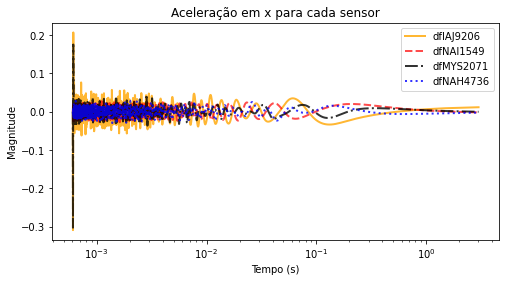

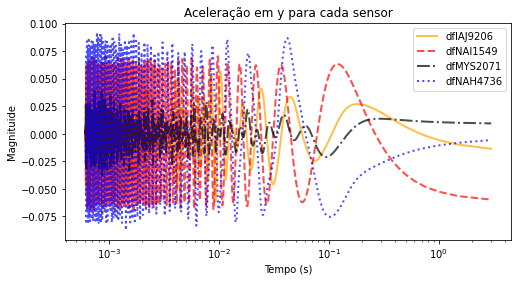

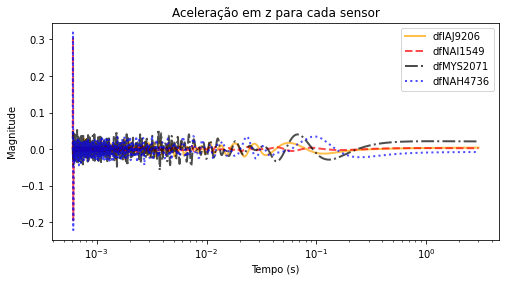

In [ ]:
fig, ax1 = plt.subplots(figsize=[8, 4])
ax1.plot(t1, dfIAJ9206['x'], color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206', alpha = 0.8)
ax1.plot(t2, dfNAI1549['x'], color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549', alpha = 0.7)
ax1.plot(t3, dfMYS2071['x'], color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071', alpha = 0.8)
ax1.plot(t4, dfNAH4736['x'], color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736', alpha = 0.8)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnitude')
plt.title('Aceleração em x para cada sensor')
plt.legend()
plt.xscale('log')

fig, ax2 = plt.subplots(figsize=[8, 4])
ax2.plot(t1, dfIAJ9206['y'], color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206', alpha = 0.7)
ax2.plot(t2, dfNAI1549['y'], color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549', alpha = 0.7)
ax2.plot(t3, dfMYS2071['y'], color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071', alpha = 0.7)
ax2.plot(t4, dfNAH4736['y'], color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736', alpha = 0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnituide')
plt.title('Aceleração em y para cada sensor')
plt.legend()
plt.xscale('log')

fig, ax3 = plt.subplots(figsize=[8, 4])
ax3.plot(t1, dfIAJ9206['z'], color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206', alpha = 0.7)
ax3.plot(t2, dfNAI1549['z'], color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549', alpha = 0.7)
ax3.plot(t3, dfMYS2071['z'], color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071', alpha = 0.7)
ax3.plot(t4, dfNAH4736['z'], color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736', alpha = 0.7)
plt.xlabel('Tempo (s)')
plt.ylabel('Magnitude')
plt.title('Aceleração em z para cada sensor')
plt.legend()
plt.xscale('log')
plt.show()

A figura seguinte mostra os sinais correspondentes no domínio da frequência. Com a retirada dos picos em 0 Hz e 50 Hz e com a aplicação dos filtros "high pass" e "low pass", percebe-se que a magnitude do sinal apresenta picos próximos menores que 200 kHz.

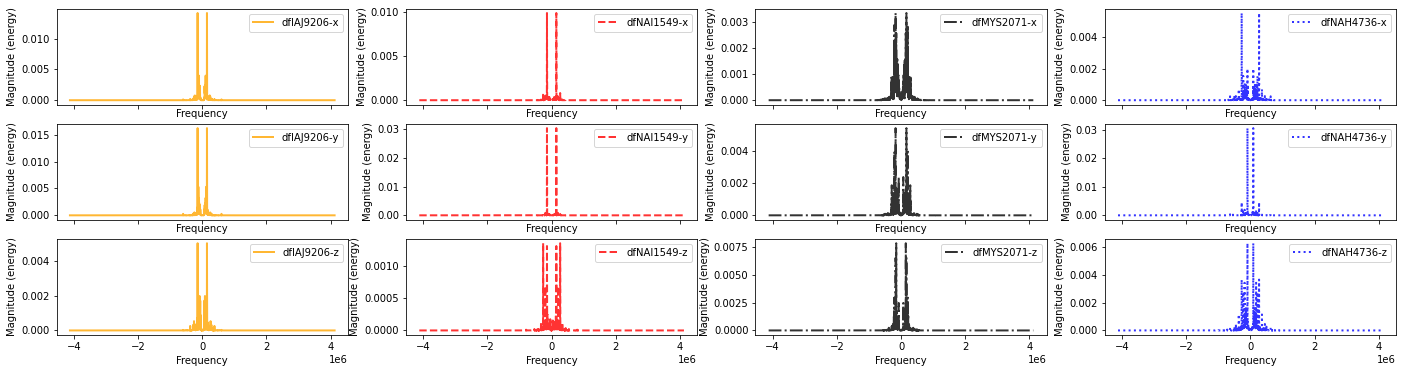

In [ ]:
fig, ax1 = plt.subplots(3,4, figsize=[24, 6], sharex=True)
ax1[0,0].magnitude_spectrum(dfIAJ9206['x'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-x', alpha = 0.8)
ax1[0,1].magnitude_spectrum(dfNAI1549['x'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-x', alpha = 0.8)
ax1[0,2].magnitude_spectrum(dfMYS2071['x'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-x', alpha = 0.8)
ax1[0,3].magnitude_spectrum(dfNAH4736['x'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-x', alpha = 0.8)

ax1[1,0].magnitude_spectrum(dfIAJ9206['y'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-y', alpha = 0.8)
ax1[1,1].magnitude_spectrum(dfNAI1549['y'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-y', alpha = 0.8)
ax1[1,2].magnitude_spectrum(dfMYS2071['y'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-y', alpha = 0.8)
ax1[1,3].magnitude_spectrum(dfNAH4736['y'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-y', alpha = 0.8)

ax1[2,0].magnitude_spectrum(dfIAJ9206['z'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-z', alpha = 0.8)
ax1[2,1].magnitude_spectrum(dfNAI1549['z'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-z', alpha = 0.8)
ax1[2,2].magnitude_spectrum(dfMYS2071['z'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-z', alpha = 0.8)
ax1[2,3].magnitude_spectrum(dfNAH4736['z'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-z', alpha = 0.8)

ax1[0,0].legend()
ax1[0,1].legend()
ax1[0,2].legend()
ax1[0,3].legend()
ax1[1,0].legend()
ax1[1,1].legend()
ax1[1,2].legend()
ax1[1,3].legend()
ax1[2,0].legend()
ax1[2,1].legend()
ax1[2,2].legend()
ax1[2,3].legend()
plt.show()

Analisando os sinais de frequência em escala logarítmica, verifica-se uma mudança no comportamento dos sinais acima de 100 kHz, com maior oscilação. Em acústica, esta frequência encontra-se no nível de ultrassom e pode, ainda, representar o ruído de fundo.

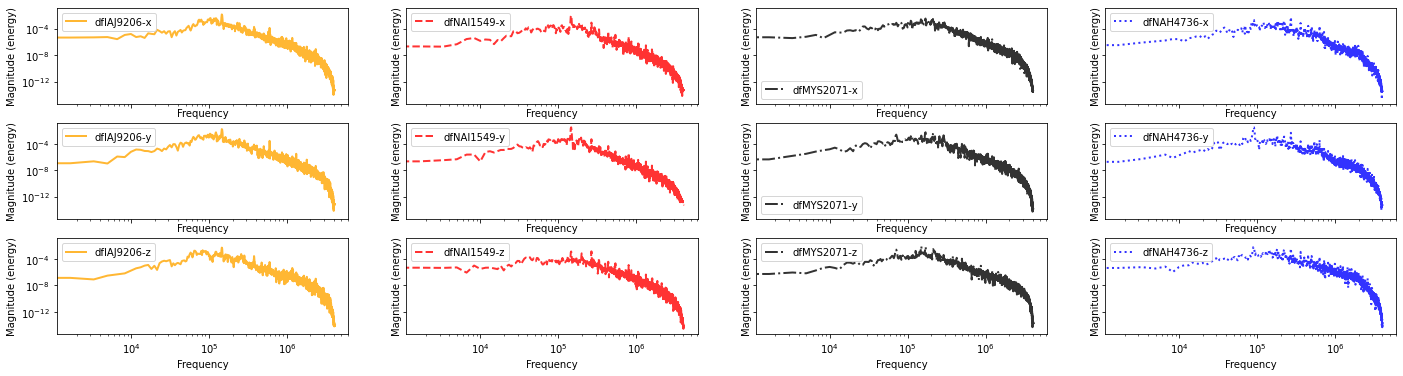

In [ ]:
fig, ax1 = plt.subplots(3,4, figsize=[24, 6], sharex=True, sharey=True)
ax1[0,0].magnitude_spectrum(dfIAJ9206['x'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-x', alpha = 0.8)
ax1[0,1].magnitude_spectrum(dfNAI1549['x'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-x', alpha = 0.8)
ax1[0,2].magnitude_spectrum(dfMYS2071['x'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-x', alpha = 0.8)
ax1[0,3].magnitude_spectrum(dfNAH4736['x'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-x', alpha = 0.8)

ax1[1,0].magnitude_spectrum(dfIAJ9206['y'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-y', alpha = 0.8)
ax1[1,1].magnitude_spectrum(dfNAI1549['y'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-y', alpha = 0.8)
ax1[1,2].magnitude_spectrum(dfMYS2071['y'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-y', alpha = 0.8)
ax1[1,3].magnitude_spectrum(dfNAH4736['y'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-y', alpha = 0.8)

ax1[2,0].magnitude_spectrum(dfIAJ9206['z'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-z', alpha = 0.8)
ax1[2,1].magnitude_spectrum(dfNAI1549['z'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-z', alpha = 0.8)
ax1[2,2].magnitude_spectrum(dfMYS2071['z'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-z', alpha = 0.8)
ax1[2,3].magnitude_spectrum(dfNAH4736['z'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-z', alpha = 0.8)

ax1[0,0].legend()
ax1[0,1].legend()
ax1[0,2].legend()
ax1[0,3].legend()
ax1[1,0].legend()
ax1[1,1].legend()
ax1[1,2].legend()
ax1[1,3].legend()
ax1[2,0].legend()
ax1[2,1].legend()
ax1[2,2].legend()
ax1[2,3].legend()
plt.xscale('log')
plt.yscale('log')

plt.show()

A figura seguinte mostra a fase de cada sensor em x, y e z após a aplicação ds filtros. Não houve mudanças aparentes na fase dos sinais, o que pode significar que os harmônicos foram mantidos.

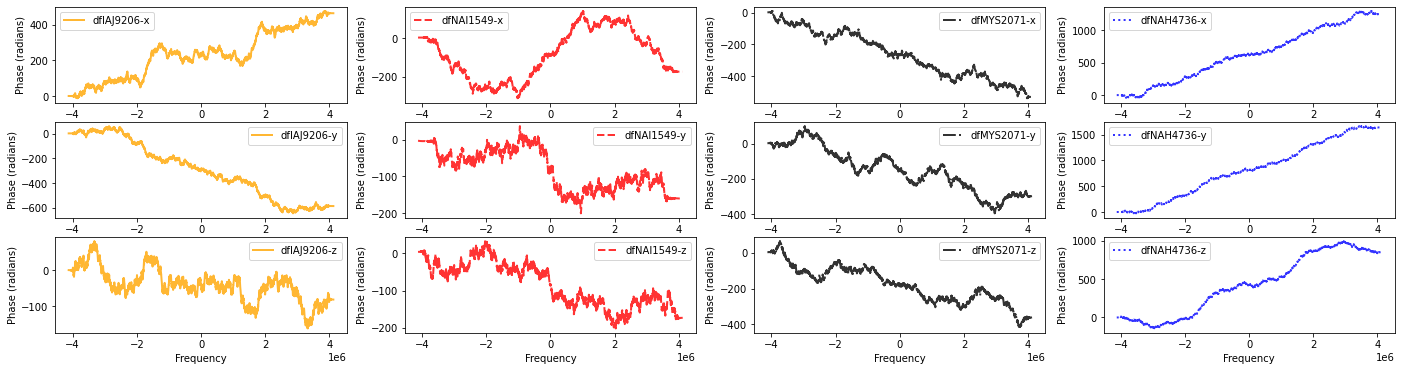

In [ ]:
fig, ax1 = plt.subplots(3,4, figsize=[24, 6])
ax1[0,0].phase_spectrum(dfIAJ9206['x'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-x', alpha = 0.8)
ax1[0,1].phase_spectrum(dfNAI1549['x'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-x', alpha = 0.8)
ax1[0,2].phase_spectrum(dfMYS2071['x'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-x', alpha = 0.8)
ax1[0,3].phase_spectrum(dfNAH4736['x'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-x', alpha = 0.8)

ax1[1,0].phase_spectrum(dfIAJ9206['y'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-y', alpha = 0.8)
ax1[1,1].phase_spectrum(dfNAI1549['y'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-y', alpha = 0.8)
ax1[1,2].phase_spectrum(dfMYS2071['y'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-y', alpha = 0.8)
ax1[1,3].phase_spectrum(dfNAH4736['y'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-y', alpha = 0.8)

ax1[2,0].phase_spectrum(dfIAJ9206['z'], Fs=Fs1, sides='twosided', color = 'orange', linewidth = 2, ls='solid', label= 'dfIAJ9206-z', alpha = 0.8)
ax1[2,1].phase_spectrum(dfNAI1549['z'], Fs=Fs2, sides='twosided', color = 'red', linewidth = 2, ls='dashed', label= 'dfNAI1549-z', alpha = 0.8)
ax1[2,2].phase_spectrum(dfMYS2071['z'], Fs=Fs3, sides='twosided', color = 'black', linewidth = 2, ls='dashdot', label= 'dfMYS2071-z', alpha = 0.8)
ax1[2,3].phase_spectrum(dfNAH4736['z'], Fs=Fs4, sides='twosided', color = 'blue', linewidth = 2, ls='dotted', label= 'dfNAH4736-z', alpha = 0.8)

plt.xlabel('Frequency')
ax1[0,0].legend()
ax1[0,1].legend()
ax1[0,2].legend()
ax1[0,3].legend()
ax1[1,0].legend()
ax1[1,1].legend()
ax1[1,2].legend()
ax1[1,3].legend()
ax1[2,0].legend()
ax1[2,1].legend()
ax1[2,2].legend()
ax1[2,3].legend()
plt.show()



4.   [Bônus] Criar uma função capaz de identificar os harmônicos e picos no domínio da frequência, de maneira a reduzir a quantidade de dados e filtrar a informação relevante.



In [ ]:
# Aplicar PCA para reduzir a quantidade de dados

# **Parte 2 - Machine Learning, Deep learning e Data Driven Solutions**

Zip instructions - Arquivos de coletas de vibração processados:

●	Os arquivos se encontram no formato CSV “*.csv”.

●	collects.csv: Contém uma lista de objetos que representam as coletas obtidas para diferentes ativos.

●	assets.csv: Contém as informações sobre os ativos aos quais as coletas fornecidas pertencem.

Foram realizadas as seguintes etapas: 

1.	Apresentar visualmente os dados contidos em cada arquivo, juntamente com as informações do ativo a que pertencem.

2.	Desenvolver um modelo/função capaz de calcular o tempo de downtime e uptime para um ativo qualquer.

3.	Desenvolver um modelo/função capaz de identificar mudanças nos padrões de vibração para um ativo qualquer.

4.	Identificar possíveis falhas nos ativos utilizando o modelo desenvolvido no item 3 ou um novo modelo.


A importação dos arquivos .csv para a segunda parte do desafio foi feita através de uma biblioteca do Google Colab, assim como na parte 1.

In [ ]:
# Upload dos arquivos de dados
from google.colab import files

uploaded2 = files.upload()

for fn in uploaded2.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded2[fn])))

Saving assets.csv to assets.csv
Saving collects.csv to collects.csv
User uploaded file "assets.csv" with length 2171 bytes
User uploaded file "collects.csv" with length 4905712 bytes


Cria-se uma lista de datasets contendo os dois dataframes importados, que são em seguida nomeados.

In [ ]:
# Criar uma lista de listas com os arquivos carregados
dfs2 = []
for fn in uploaded2:
    dfs2.append(pd.read_csv(fn))

In [ ]:
# Transformar cada lista de dfs em um dataframe
assets = pd.DataFrame(dfs2[0])
collects = pd.DataFrame(dfs2[1])

Abaixo são visualizadas as primeiras linhas do dataframe assets, que contem especificações como o tipo de equipamento (modelType) em que o sensor está acoplado, a orientação dos eixos (axial/vertical) e horizontal), a identificação de cada sensor, potência, rotações por minuto (rpm), temperatura máxima e tempo de downtime. Alguns dados faltantes precisam ser preenchidos para a utilização do dataframe.

In [ ]:
assets.head()

,_id,company,createdAt,description,model,modelType,name,sensors,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays
0,602fac7228aba1048d473cc4,5fb2c4eb1369a4325dc4545f,2021-02-19T12:17:54.457Z,NaN,60241102ed8ef30e9d309af9,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,"[""IAJ9206""]",vertical,horizontal,axial,48.00,NaN,3.7,1735.0,NaN
1,5fd0e297bf7d581c1823b8e4,5fbbadeb82a6b901c26df618,2020-12-09T14:43:35.168Z,NaN,5fd0cf96bf7d581c1823b4c4,heaterFurnace,RDF-61.1,"[""LZY4270""]",axial,vertical,horizontal,0.25,55.0,0.0,1740.0,NaN
2,5fb286de1369a4325dc45433,5f6b83e34dd69d4bc799ea1f,2020-11-16T14:04:14.564Z,-,5fb275981369a4325dc4542e,transformer,TRANSFORMADOR 500 KVA N°1,"[""MUR8453""]",horizontal,vertical,NaN,NaN,65.0,NaN,NaN,NaN
3,6023fad9ed8ef30e9d30952b,5fb2c4eb1369a4325dc4545f,2021-02-10T15:25:13.265Z,NaN,6023f7dced8ef30e9d30945f,pump,Motor Bomba - Tanque de Expansão Tubo Verde,"[""MXK6435""]",horizontal,axial,vertical,48.00,NaN,7.0,3525.0,NaN
4,5ff71a150b6abb7be05083b0,5f17203f640a00cc08cb1b3d,2021-01-07T14:26:29.726Z,NaN,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.12- Motor,"[""MYD8706""]",horizontal,axial,vertical,NaN,NaN,30.0,1765.0,NaN


A coluna com o id dos sensores foi formatada e algumas colunas foram apagadas.

In [ ]:
new = assets['sensors'].astype(str)
new1 = new.str.split('"', n=3, expand=True)
assets['sensor']=new1[1]

In [ ]:
del(assets['sensors'])

In [ ]:
del(assets['_id'])
del(assets['company'])
del(assets['description'])

In [ ]:
assets

,createdAt,model,modelType,name,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays,sensor
0,2021-02-19T12:17:54.457Z,60241102ed8ef30e9d309af9,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.00,NaN,3.7,1735.0,NaN,IAJ9206
1,2020-12-09T14:43:35.168Z,5fd0cf96bf7d581c1823b4c4,heaterFurnace,RDF-61.1,axial,vertical,horizontal,0.25,55.0,0.0,1740.0,NaN,LZY4270
2,2020-11-16T14:04:14.564Z,5fb275981369a4325dc4542e,transformer,TRANSFORMADOR 500 KVA N°1,horizontal,vertical,NaN,NaN,65.0,NaN,NaN,NaN,MUR8453
3,2021-02-10T15:25:13.265Z,6023f7dced8ef30e9d30945f,pump,Motor Bomba - Tanque de Expansão Tubo Verde,horizontal,axial,vertical,48.00,NaN,7.0,3525.0,NaN,MXK6435
4,2021-01-07T14:26:29.726Z,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.12- Motor,horizontal,axial,vertical,NaN,NaN,30.0,1765.0,NaN,MYD8706
5,2020-12-09T17:07:13.817Z,5fd10441bf7d581c1823bf80,heaterFurnace,VTF-61.1,axial,radial,horizontal,0.25,60.0,1.5,894.0,[],MYS2071
6,2020-10-23T13:22:33.577Z,604a3f1ba76ffc0ebb727d05,eletricMotor,Boko MA-1510 - Motor 2 da UH,horizontal,vertical,radial,NaN,65.0,37.0,1750.0,"[0,1,2,3,4,5]",MZU6388
7,2021-02-19T13:09:54.165Z,60241102ed8ef30e9d309af9,compressor,Ventilador -GA75 FF - Prédio B104,NaN,NaN,NaN,48.00,NaN,2.0,1080.0,NaN,NAH4736
8,2021-01-07T16:18:52.234Z,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.3- Motor,axial,horizontal,vertical,NaN,NaN,75.0,1775.0,NaN,NAI1549
9,2020-09-28T12:17:13.295Z,5f71d44867198d5d37e27d4f,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.00,70.0,NaN,1458.0,NaN,NEW4797


O dataframe collects contém dados de várias medições realizadas para os sensores listados em assets. Como a quantidade de dados é grande em relação ao número de valores nulos, optou-se por remover os valores nulos.

In [ ]:
collects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33901 entries, 0 to 33900
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                33901 non-null  object 
 1   createdAt          33901 non-null  object 
 2   params.accelRMS.x  33441 non-null  float64
 3   params.accelRMS.y  33441 non-null  float64
 4   params.accelRMS.z  33441 non-null  float64
 5   params.duration    33441 non-null  float64
 6   params.sampRate    33441 non-null  float64
 7   params.timeStart   33441 non-null  float64
 8   params.velRMS.x    33441 non-null  float64
 9   params.velRMS.y    33441 non-null  float64
 10  params.velRMS.z    33441 non-null  float64
 11  sensorId           33901 non-null  object 
 12  temp               33901 non-null  float64
dtypes: float64(10), object(3)
memory usage: 3.4+ MB


In [ ]:
collects = collects.dropna()

Após remover os valores nulos, foram avaliadas as estatísticas do dataframe collects. Os valores de aceleração e velocidade têm desvio-padrão superior à média porque alguns sensores têm picos muito maiores que outros.

In [ ]:
collects.describe()

,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,params.velRMS.z,temp
count,33441.000000,33441.000000,33441.000000,33441.000000,33441.000000,3.344100e+04,33441.000000,33441.000000,33441.000000,33441.000000
mean,0.043309,0.045615,0.051230,3.161312,1539.002670,1.624086e+09,0.000819,0.001338,0.000820,30.827877
std,0.057018,0.056718,0.061414,0.496564,285.423158,9.116588e+05,0.000885,0.001959,0.000815,13.419106
min,0.000618,0.000686,0.000836,1.961000,103.724069,1.622506e+09,0.000043,0.000039,0.000058,-45.540000
25%,0.008124,0.004894,0.012020,2.957000,1656.686627,1.623296e+09,0.000189,0.000119,0.000255,18.810000
50%,0.021122,0.020673,0.016684,3.006000,1656.686627,1.624112e+09,0.000344,0.000254,0.000366,30.060000
75%,0.070873,0.062698,0.081715,3.006000,1684.139330,1.624902e+09,0.001288,0.001857,0.001524,39.060000
max,0.321101,0.498345,0.446166,5.444000,2110.657828,1.625620e+09,0.012329,0.009980,0.004638,132.160000


As 3 figuras seguintes mostram os histogramas daaveleração RMS em x, y e z para todos os sensores. As distribuições não são normais e apresentam picos em valores semelhantes de aceleração, porém alguns sensores apresentam muito mais picos do que os outros.

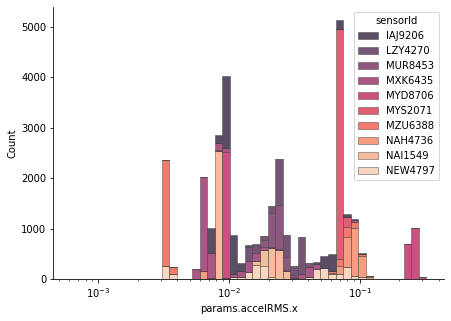

In [ ]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(collects['params.accelRMS.x'], x=collects['params.accelRMS.x'], hue=collects['sensorId'], multiple="stack", palette="rocket", edgecolor=".3",
    linewidth=.5, log_scale=True, kde=False, ax=ax)
plt.show()

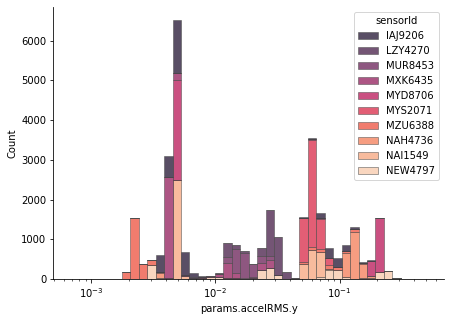

In [ ]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(collects['params.accelRMS.y'], x=collects['params.accelRMS.y'], hue=collects['sensorId'], multiple="stack", palette="rocket", edgecolor=".3",
    linewidth=.5, log_scale=True, kde=False, ax=ax)
plt.show()

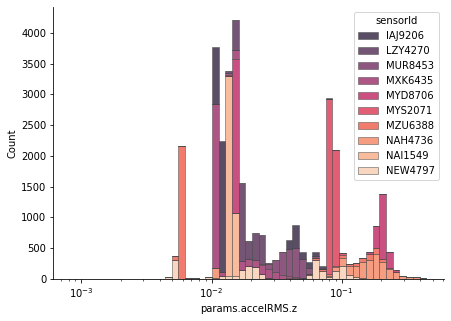

In [ ]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

sns.histplot(collects['params.accelRMS.z'], x=collects['params.accelRMS.z'], hue=collects['sensorId'], multiple="stack", palette="rocket", edgecolor=".3",
    linewidth=.5, log_scale=True, kde=False, ax=ax)
plt.show()

Os dados do dataframe collects reúnem séries temporais de aceleração RMS  e velocidade RMS para cada sensor, onde params.timeStart pode ser considerado o instante de tempo da respectiva medição instantânea. Estes dados foram agrupados por sensor e o dataframe **ativos** retorna a quantidade de medições para cada sensor.

In [ ]:
ativos = collects.groupby('sensorId').count()
ativos

,_id,createdAt,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,params.velRMS.z,temp
sensorId,,,,,,,,,,,,
IAJ9206,3926,3926,3926,3926,3926,3926,3926,3926,3926,3926,3926,3926
LZY4270,2995,2995,2995,2995,2995,2995,2995,2995,2995,2995,2995,2995
MUR8453,2027,2027,2027,2027,2027,2027,2027,2027,2027,2027,2027,2027
MXK6435,3806,3806,3806,3806,3806,3806,3806,3806,3806,3806,3806,3806
MYD8706,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290,4290
MYS2071,4756,4756,4756,4756,4756,4756,4756,4756,4756,4756,4756,4756
MZU6388,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788,2788
NAH4736,2363,2363,2363,2363,2363,2363,2363,2363,2363,2363,2363,2363
NAI1549,4279,4279,4279,4279,4279,4279,4279,4279,4279,4279,4279,4279


A figura seguinte mostra a quantidade de medições para cada sensor, que varia entre 2000 e 5000 amostras.

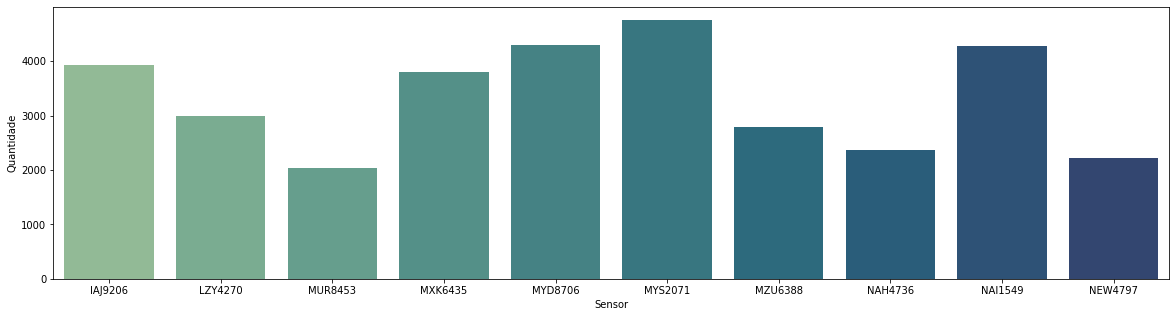

In [ ]:
# Quantidade de ativos para cada sensor ID
f, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x=ativos.index, y=ativos['_id'], palette="crest", ax=ax)
plt.xlabel('Sensor')
plt.ylabel('Quantidade')
plt.show()

A figura seguinte mostra os boxplots de aceleração RMS em x, y e z para cada sensor. O sensor MYD8716 não apresentou outliers e tem grande variação nos valores de aceleração em comparação com os demais sensores.

Os sensores IAJ9206 e MZU6388 apresentaram uma grande quantidade de outliers acima do último quartil, que podem representar picos ou anomalias. Alguns dos sensores têm uma variação muito pequena em seus valores de aceleração, o que pode indicar estabilidade nos padrões de vibração.

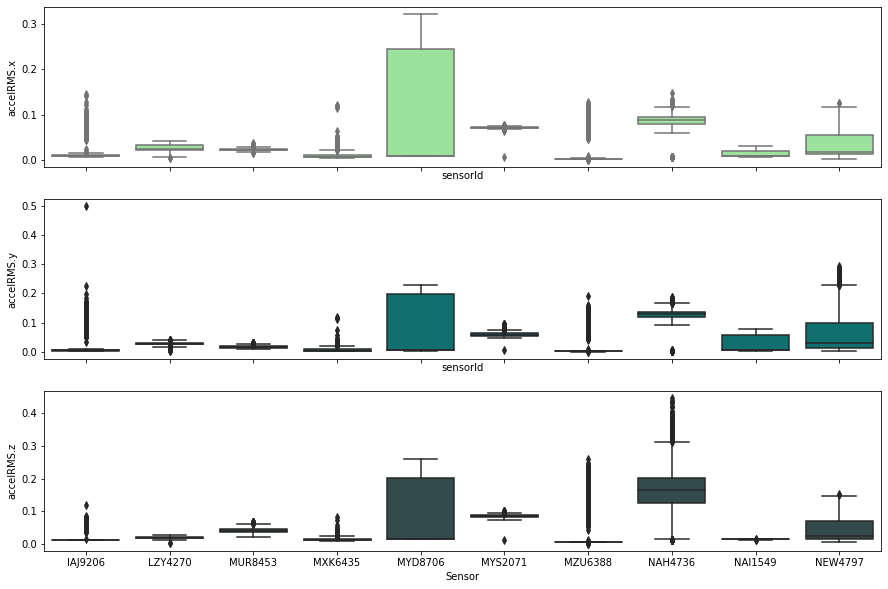

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(15, 10), sharex=True)

sns.boxplot(x=collects['sensorId'], y=collects['params.accelRMS.x'], ax=ax1, color="lightgreen")
sns.boxplot(x=collects['sensorId'], y=collects['params.accelRMS.y'], ax=ax2, color="teal")
sns.boxplot(x=collects['sensorId'], y=collects['params.accelRMS.z'], ax=ax3, color="darkslategrey")
plt.xlabel('Sensor')
ax1.set_ylabel('accelRMS.x')
ax2.set_ylabel('accelRMS.y')
ax3.set_ylabel('accelRMS.z')
plt.show()

Os gráficos abaixo mostram os padrões de aceleração RMS de cada sensor ao longo do tempo. É possível notar algumas lacunas temporais que indicam indisponibilidade do sensor e picos que podem indicar anomalias.

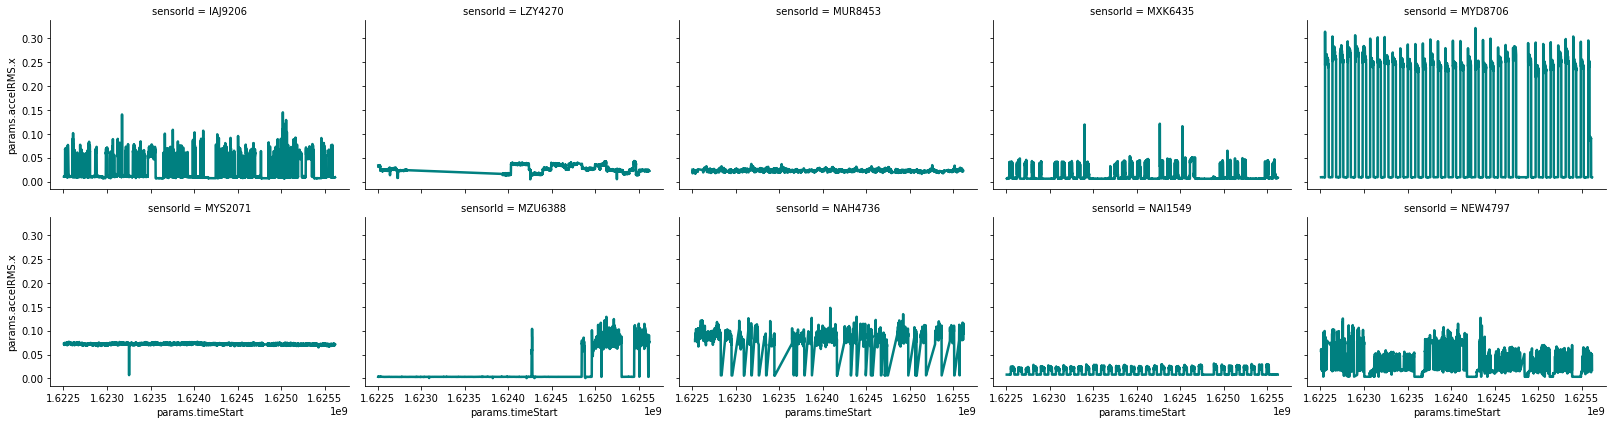

In [ ]:
sns.relplot(x=collects['params.timeStart'], y=collects['params.accelRMS.x'], 
            col=collects['sensorId'], col_wrap=5,
            height=3, aspect=1.5, linewidth=2.5,
            kind="line", color='teal');

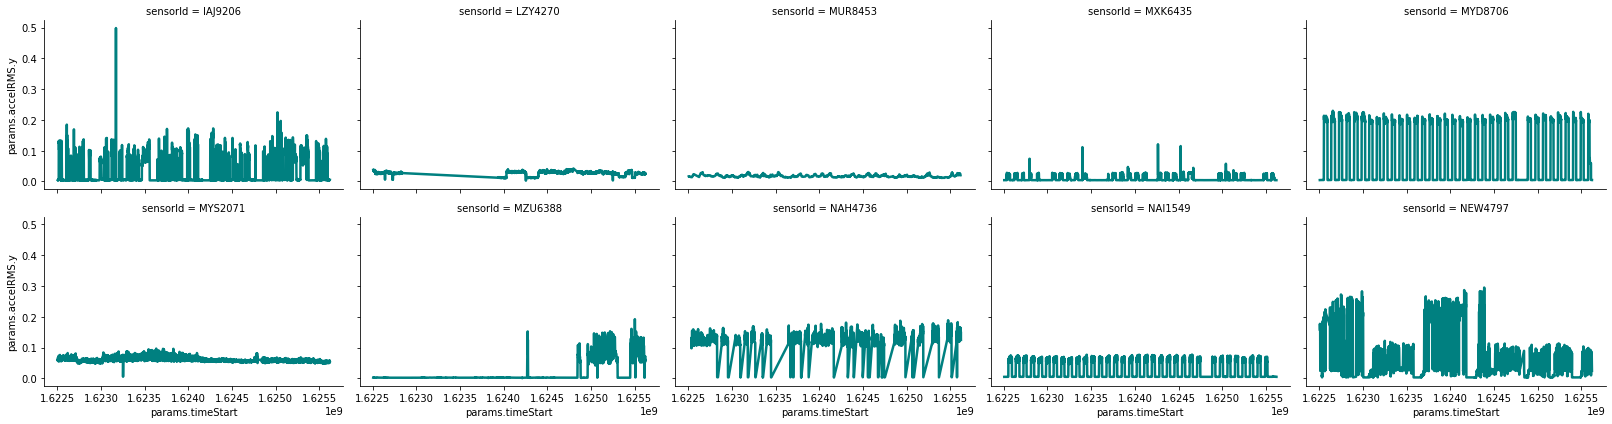

In [ ]:
sns.relplot(x=collects['params.timeStart'], y=collects['params.accelRMS.y'], 
            col=collects['sensorId'], col_wrap=5,
            height=3, aspect=1.5, linewidth=2.5,
            kind="line", color='teal');

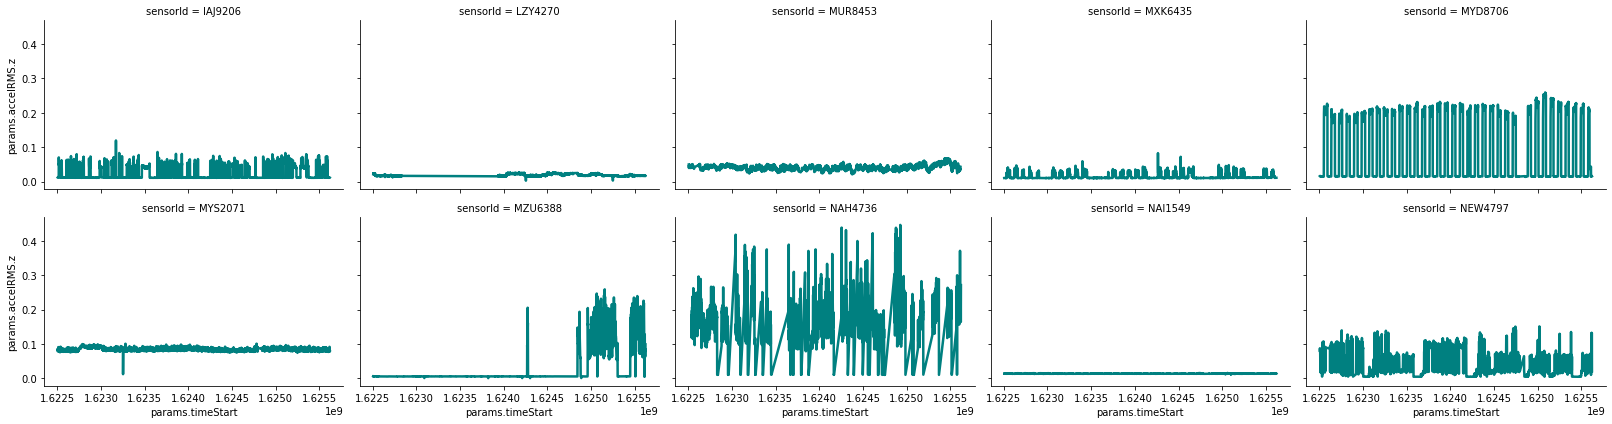

In [ ]:
sns.relplot(x=collects['params.timeStart'], y=collects['params.accelRMS.z'], 
            col=collects['sensorId'], col_wrap=5,
            height=3, aspect=1.5, linewidth=2.5,
            kind="line", color='teal');

**2.	Desenvolver um modelo/função capaz de calcular o tempo de downtime e uptime para um ativo qualquer.**

Profissionais de TI usam o uptime como uma taxa percentual entre o tempo de inatividade (downtime) e o tempo de atividade do servidor.

uptime = MTBF/(MTBF+MTTR)

onde:

MTBF = Mean Time Between Failures

MTTR = Maximum Time To Repair

O resultado do uptime é dado em porcentagem e indica o grau de disponibilidade do ativo.

Fonte: https://www.valuehost.com.br/blog/o-que-e-uptime/

In [ ]:
# No dataframe "assets" consta o tempo máximo de downtime para cada sensorId, porém alguns sensores não têm essa informação. Este valor será o MTTR na equação do uptime.
assets

,createdAt,model,modelType,name,specifications.axisX,specifications.axisY,specifications.axisZ,specifications.maxDowntime,specifications.maxTemp,specifications.power,specifications.rpm,specifications.workdays,sensor
0,2021-02-19T12:17:54.457Z,60241102ed8ef30e9d309af9,compressor,Ventilador Acima do Elemento GA160 FF - Prédio...,vertical,horizontal,axial,48.00,NaN,3.7,1735.0,NaN,IAJ9206
1,2020-12-09T14:43:35.168Z,5fd0cf96bf7d581c1823b4c4,heaterFurnace,RDF-61.1,axial,vertical,horizontal,0.25,55.0,0.0,1740.0,NaN,LZY4270
2,2020-11-16T14:04:14.564Z,5fb275981369a4325dc4542e,transformer,TRANSFORMADOR 500 KVA N°1,horizontal,vertical,NaN,NaN,65.0,NaN,NaN,NaN,MUR8453
3,2021-02-10T15:25:13.265Z,6023f7dced8ef30e9d30945f,pump,Motor Bomba - Tanque de Expansão Tubo Verde,horizontal,axial,vertical,48.00,NaN,7.0,3525.0,NaN,MXK6435
4,2021-01-07T14:26:29.726Z,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.12- Motor,horizontal,axial,vertical,NaN,NaN,30.0,1765.0,NaN,MYD8706
5,2020-12-09T17:07:13.817Z,5fd10441bf7d581c1823bf80,heaterFurnace,VTF-61.1,axial,radial,horizontal,0.25,60.0,1.5,894.0,[],MYS2071
6,2020-10-23T13:22:33.577Z,604a3f1ba76ffc0ebb727d05,eletricMotor,Boko MA-1510 - Motor 2 da UH,horizontal,vertical,radial,NaN,65.0,37.0,1750.0,"[0,1,2,3,4,5]",MZU6388
7,2021-02-19T13:09:54.165Z,60241102ed8ef30e9d309af9,compressor,Ventilador -GA75 FF - Prédio B104,NaN,NaN,NaN,48.00,NaN,2.0,1080.0,NaN,NAH4736
8,2021-01-07T16:18:52.234Z,5ff5a854adacd8372cf06950,pump,CAG1- BAGS.3- Motor,axial,horizontal,vertical,NaN,NaN,75.0,1775.0,NaN,NAI1549
9,2020-09-28T12:17:13.295Z,5f71d44867198d5d37e27d4f,other,ROTULADORA SIDEL,NaN,NaN,NaN,1.00,70.0,NaN,1458.0,NaN,NEW4797


In [ ]:
# Preencher os valores numéricos faltantes com a média
assets = assets.fillna(assets.mean())

In [ ]:
# Para obter o MTBF, agrupamos os sensores no dataframe "collects" pela média e consideramos o MTBF como sendo a variável "params.duration".
ativos2 = collects.groupby('sensorId').mean()

In [ ]:
# O índice foi transformado em uma coluna com o nome de cada sensor no dataframe ativos2.
ativos2['sensorId'] = ativos2.index
ativos2

,params.accelRMS.x,params.accelRMS.y,params.accelRMS.z,params.duration,params.sampRate,params.timeStart,params.velRMS.x,params.velRMS.y,params.velRMS.z,temp,sensorId
sensorId,,,,,,,,,,,
IAJ9206,0.021404,0.024750,0.019857,3.006009,1656.681856,1.624050e+09,0.000814,0.000858,0.000533,29.680665,IAJ9206
LZY4270,0.026469,0.026447,0.018814,3.006679,1655.641564,1.624421e+09,0.000388,0.000266,0.000284,35.914377,LZY4270
MUR8453,0.023219,0.017593,0.041024,4.724250,878.606124,1.624142e+09,0.000319,0.000218,0.000588,40.907612,MUR8453
MXK6435,0.011540,0.008216,0.014248,3.006000,1656.686627,1.624056e+09,0.000236,0.000128,0.000162,17.658592,MXK6435
MYD8706,0.108592,0.085089,0.092770,2.957159,1684.050122,1.624049e+09,0.001548,0.001281,0.000890,23.295079,MYD8706
MYS2071,0.071764,0.060427,0.084543,3.006000,1656.686395,1.624055e+09,0.001309,0.001760,0.001832,35.921192,MYS2071
MZU6388,0.018992,0.019094,0.032515,4.003177,830.782095,1.624027e+09,0.000273,0.000300,0.000343,21.620104,MZU6388
NAH4736,0.083372,0.121919,0.165449,3.006053,1656.657483,1.623976e+09,0.001779,0.006896,0.002547,54.077033,NAH4736
NAI1549,0.013598,0.027796,0.013926,2.957091,1684.088404,1.624050e+09,0.000543,0.001375,0.000323,18.188032,NAI1549


In [ ]:
# Foi criado um dataframe com o tempo máximo de downtime de cada sensor
downtime = pd.DataFrame()
downtime['sensor'] = ativos2.index
downtime['max_downtime'] = assets['specifications.maxDowntime']
downtime

,sensor,max_downtime
0,IAJ9206,48.00
1,LZY4270,0.25
2,MUR8453,24.25
3,MXK6435,48.00
4,MYD8706,24.25
5,MYS2071,0.25
6,MZU6388,24.25
7,NAH4736,48.00
8,NAI1549,24.25
9,NEW4797,1.00


In [ ]:
# Como exemplo, para o sensor LZY4270 temos:
uptime_t = 100*3.006009/(3.006009+0.25)
print('Uptime: ', round(uptime_t), '%')

Uptime:  92 %


In [ ]:
downtime = pd.to_numeric(assets['specifications.maxDowntime'])
type(downtime)

pandas.core.series.Series

In [ ]:
# Foram atribuídos números aos sensores para facilitar o uso da função de cálculo do tempo de uptime e downtime.
mean_duration = pd.DataFrame()
mean_duration['mean_uptime'] = ativos2['params.duration']
mean_duration['sensor'] = mean_duration.index
mean_duration=mean_duration.replace('IAJ9206', 1)
mean_duration=mean_duration.replace('LZY4270', 2)
mean_duration=mean_duration.replace('MUR8453', 3)
mean_duration=mean_duration.replace('MXK6435', 4)
mean_duration=mean_duration.replace('MYD8706', 5)
mean_duration=mean_duration.replace('MYS2071', 6)
mean_duration=mean_duration.replace('MZU6388', 7)
mean_duration=mean_duration.replace('NAH4736', 8)
mean_duration=mean_duration.replace('NAI1549', 9)
mean_duration=mean_duration.replace('NEW4797', 10)
mean_duration['uptime (%)'] = 100*mean_duration['mean_uptime']/(mean_duration['mean_uptime']+assets['specifications.maxDowntime'])
mean_duration

,mean_uptime,sensor,uptime (%)
sensorId,,,
IAJ9206,3.006009,1,NaN
LZY4270,3.006679,2,NaN
MUR8453,4.724250,3,NaN
MXK6435,3.006000,4,NaN
MYD8706,2.957159,5,NaN
MYS2071,3.006000,6,NaN
MZU6388,4.003177,7,NaN
NAH4736,3.006053,8,NaN
NAI1549,2.957091,9,NaN


In [ ]:
def calc_uptime():
  sensor = int(input('Digite o número do sensor correspondente da lista:\n'
   '1 - IAJ9206\n2 - LZY4270\n3 - MUR8453\n4 - MXK6435\n5 - MYD8706\n'
   '6 - MYS2071\n7 - MZU6388\n8 - NAH4736\n9 - NAI1549\n10 - NEW4797\n'))
  if(downtime['sensor'] is sensor):
    uptime = 100*(mean_duration['params.duration'])/(mean_duration['params.duration']+downtime['specifications.maxDowntime'])
    print('Uptime: ', uptime, '%')

In [ ]:
calc_uptime()

Digite o número do sensor correspondente da lista:
1 - IAJ9206
2 - LZY4270
3 - MUR8453
4 - MXK6435
5 - MYD8706
6 - MYS2071
7 - MZU6388
8 - NAH4736
9 - NAI1549
10 - NEW4797
1


A função anterior apresentou calcula o tempo de uptime de cada sensor, porém apresentou um bug que não pôde ser corrigido.

In [ ]:
def calc_uptime():
  sensor = int(input('Digite o número do sensor correspondente da lista:\n'
   '1 - IAJ9206\n2 - LZY4270\n3 - MUR8453\n4 - MXK6435\n5 - MYD8706\n'
   '6 - MYS2071\n7 - MZU6388\n8 - NAH4736\n9 - NAI1549\n10 - NEW4797\n'))
  for i in ativos2:
    if(ativos2['sensorId'] is sensor):
      print('Tempo de uptime: ', ativos3['params.duration'], 's')
      print('Tempo de downtime: ', assets['specifications.maxDowntime'])
      print('Uptime: ', ativos2['params.duration']/(ativos2['params.duration']+assets['specifications.maxDowntime']))
    else:
      print('Não foi possível executar a operação.')

In [ ]:
calc_uptime()

Digite o número do sensor correspondente da lista:
1 - IAJ9206
2 - LZY4270
3 - MUR8453
4 - MXK6435
5 - MYD8706
6 - MYS2071
7 - MZU6388
8 - NAH4736
9 - NAI1549
10 - NEW4797
1
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.
Não foi possível executar a operação.


In [ ]:
uptimex = pd.DataFrame()
uptimex['sensorId'] = collects['sensorId']
uptimex['acxRMS'] = collects['params.accelRMS.x']
uptimex['params.timeStart'] = collects['params.timeStart']
uptimex

,sensorId,acxRMS,params.timeStart
0,IAJ9206,0.010463,1.622506e+09
1,IAJ9206,0.011437,1.622507e+09
2,IAJ9206,0.010494,1.622507e+09
3,IAJ9206,0.009859,1.622508e+09
4,IAJ9206,0.010014,1.622509e+09
...,...,...,...
33896,NEW4797,0.048851,1.625616e+09
33897,NEW4797,0.049630,1.625617e+09
33898,NEW4797,0.048705,1.625618e+09
33899,NEW4797,0.049600,1.625619e+09


In [ ]:
uptimex=uptimex.replace('IAJ9206', 1)
uptimex=uptimex.replace('LZY4270', 2)
uptimex=uptimex.replace('MUR8453', 3)
uptimex=uptimex.replace('MXK6435', 4)
uptimex=uptimex.replace('MYD8706', 5)
uptimex=uptimex.replace('MYS2071', 6)
uptimex=uptimex.replace('MZU6388', 7)
uptimex=uptimex.replace('NAH4736', 8)
uptimex=uptimex.replace('NAI1549', 9)
uptimex=uptimex.replace('NEW4797', 10)

uptimex

,sensorId,acxRMS,params.timeStart
0,1,0.010463,1.622506e+09
1,1,0.011437,1.622507e+09
2,1,0.010494,1.622507e+09
3,1,0.009859,1.622508e+09
4,1,0.010014,1.622509e+09
...,...,...,...
33896,10,0.048851,1.625616e+09
33897,10,0.049630,1.625617e+09
33898,10,0.048705,1.625618e+09
33899,10,0.049600,1.625619e+09


In [ ]:
def calc_uptime():
  uptime = 0.0001
  downtime = 0.0001
  sensor = int(input('Digite o número do sensor correspondente da lista:\n'
   '1 - IAJ9206\n2 - LZY4270\n3 - MUR8453\n4 - MXK6435\n5 - MYD8706\n'
   '6 - MYS2071\n7 - MZU6388\n8 - NAH4736\n9 - NAI1549\n10 - NEW4797\n'))

  if (uptimex['sensorId'].item is sensor and uptimex['acxRMS'] < 0.0001):
      downtime = downtime + uptimmex['params.timeStart']
      
  if (uptimex['sensorId'].item is sensor and uptimex['acxRMS'] >= 0.0001):
      uptime = uptime + uptimmex['params.timeStart']
 
  print('Tempo de downtime: ', downtime, 's')    
  print('Tempo de downtime: ', downtime, 's')
  print('Uptime: ', (100*uptime/(uptime+downtime)), '%')

In [ ]:
calc_uptime()

Digite o número do sensor correspondente da lista:
1 - IAJ9206
2 - LZY4270
3 - MUR8453
4 - MXK6435
5 - MYD8706
6 - MYS2071
7 - MZU6388
8 - NAH4736
9 - NAI1549
10 - NEW4797
1
Tempo de downtime:  0.0001 s
Tempo de downtime:  0.0001 s
Uptime:  50.0 %


Diferentes versões da função para o cálculo do tempo de uptime foram desenvolvidas, porém o bug encontrado não pôde ser corrigido em tempo hábil.

**3. Desenvolver um modelo/função capaz de identificar mudanças nos padrões de vibração para um ativo qualquer.**

**4. Identificar possíveis falhas nos ativos utilizando o modelo desenvolvido no item 3 ou um novo modelo (a identificação deve ser autônoma e não uma análise visual).**

Estes dois itens foram feitos em paralelo. Um modelo para a detecção de anomalias foi desenvolvido com base no algoritmo LSTM. Os dados do dataframe collects foram separados em dataframes individuais para cada sensor e um deles foi usado para testar o modelo.

Com base nas séries temporais, foi densenvolvido um modelo para identificar e prever anomalias para um sensor individual. Para isto os dados foram separados em datasets auxiliares para cada sensor.

In [ ]:
IAJ9206 = collects.loc[collects['sensorId'] == 'IAJ9206']
LZY4270 = collects.loc[collects['sensorId'] == 'LZY4270']
MUR8453 = collects.loc[collects['sensorId'] == 'MUR8453']
MXK6435 = collects.loc[collects['sensorId'] == 'MXK6435']
MYD8706 = collects.loc[collects['sensorId'] == 'MYD8706']
MYS2071 = collects.loc[collects['sensorId'] == 'MYS2071']
MZU6388 = collects.loc[collects['sensorId'] == 'MZU6388']
NAH4736 = collects.loc[collects['sensorId'] == 'NAH4736']
NAI1549 = collects.loc[collects['sensorId'] == 'NAI1549']
NEW4797 = collects.loc[collects['sensorId'] == 'NEW4797']

In [ ]:
NAH4736.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2363 entries, 24946 to 27308
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                2363 non-null   object 
 1   createdAt          2363 non-null   object 
 2   params.accelRMS.x  2363 non-null   float64
 3   params.accelRMS.y  2363 non-null   float64
 4   params.accelRMS.z  2363 non-null   float64
 5   params.duration    2363 non-null   float64
 6   params.sampRate    2363 non-null   float64
 7   params.timeStart   2363 non-null   float64
 8   params.velRMS.x    2363 non-null   float64
 9   params.velRMS.y    2363 non-null   float64
 10  params.velRMS.z    2363 non-null   float64
 11  sensorId           2363 non-null   object 
 12  temp               2363 non-null   float64
dtypes: float64(10), object(3)
memory usage: 258.5+ KB


In [ ]:
from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Definir o random seed
seed(10)
tf.random.set_seed(10)

In [ ]:
# Definir conjuntos de dados de treino e teste
#X = pd.Series.to_frame(IAJ9206['params.timeStart'])
X = pd.Series.to_frame(NAH4736['params.accelRMS.x'])

In [ ]:
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0) #dividindo o df em treinamento (80%) e teste (20%)

In [ ]:
Xtrain_fft = np.fft.fft(X_train)
Xtest_fft = np.fft.fft(X_test)

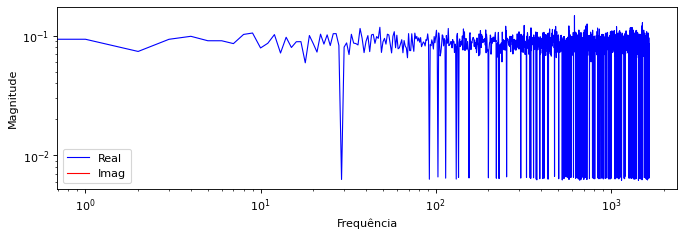

In [ ]:
# Frequências do sinal dos dados de treino
fig, ax = plt.subplots(figsize=(10, 3), dpi=80)
ax.plot(Xtrain_fft.real, label='Real', color='blue', animated = True, linewidth=1)
ax.plot(Xtrain_fft.imag, label='Imag', color='red', animated = True, linewidth=1)
plt.xscale('log')
plt.xlabel('Frequência')
plt.yscale('log')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

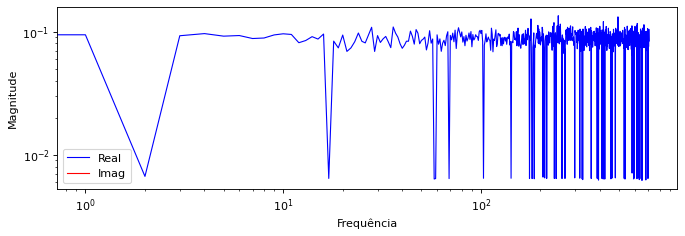

In [ ]:
# Frequência do sinal dos dados de teste
fig, ax = plt.subplots(figsize=(10, 3), dpi=80)
ax.plot(Xtest_fft.real, label='Real', color='blue', animated = True, linewidth=1)
ax.plot(Xtest_fft.imag, label='Imag', color='red', animated = True, linewidth=1)
plt.xscale('log')
plt.xlabel('Frequência')
plt.yscale('log')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

Observa-se um comportamento instável nos sinais de frequência da aceleração RMS em x para o sensor NAH4736.

In [ ]:
# Normalização dos dados
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
scaler_filename = "scaler_data"


In [ ]:
# Reshape das entradas para aplicação do modelo LSTM
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)

Training data shape: (1654, 1, 1)
Test data shape: (709, 1, 1)


In [ ]:
# Auto encoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu', return_sequences=True, 
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# Criação do modelo
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 16)             1152      
                                                                 
 lstm_5 (LSTM)               (None, 4)                 336       
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 4)             0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 1, 4)              144       
                                                                 
 lstm_7 (LSTM)               (None, 1, 16)             1344      
                                                           

In [ ]:
# Fit do modelo aos dados
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Epoch 1/100
158/158 [==============================] - 5s 8ms/step - loss: 0.4110 - val_loss: 0.1634
Epoch 2/100
158/158 [==============================] - 1s 5ms/step - loss: 0.0789 - val_loss: 0.0770
Epoch 3/100
158/158 [==============================] - 1s 4ms/step - loss: 0.0558 - val_loss: 0.0536
Epoch 4/100
158/158 [==============================] - 1s 5ms/step - loss: 0.0327 - val_loss: 0.0327
Epoch 5/100
158/158 [==============================] - 1s 5ms/step - loss: 0.0247 - val_loss: 0.0299
Epoch 6/100
158/158 [==============================] - 1s 4ms/step - loss: 0.0230 - val_loss: 0.0277
Epoch 7/100
158/158 [==============================] - 1s 4ms/step - loss: 0.0209 - val_loss: 0.0270
Epoch 8/100
158/158 [==============================] - 1s 5ms/step - loss: 0.0192 - val_loss: 0.0240
Epoch 9/100
158/158 [==============================] - 1s 4ms/step - loss: 0.0178 - val_loss: 0.0221
Epoch 10/100
158/158 [==============================] - 1s 5ms/step - loss: 0.0171 - val_lo

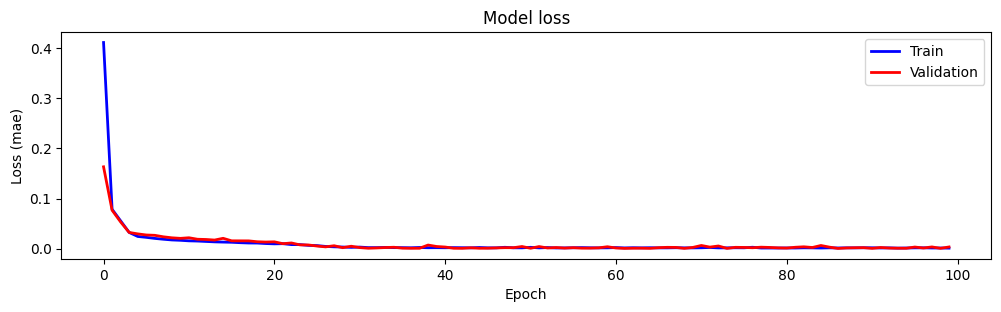

In [ ]:
# Perdas do treino do modelo
fig, ax = plt.subplots(figsize=(12, 3), dpi=100)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=12)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper middle')
plt.show()

# Distribuição da função de perda (loss function)

Ao plotar a distribuição da perda calculada no conjunto de dados de treino, podemos ter uma base para identificar o limite acima do qual o sinal classifica-se como anomalia. Com isto, temos mais segurança de que este limite está sendo definido acima do nível de ruído e que as anomalias são estatisticamente significantes frente ao ruído de fundo.

In [ ]:
# Plot da distribuição de perdas para os dados de treino
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

In [ ]:
scored = pd.DataFrame(X_train.shape)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)


(0.0, 0.004724127268113815)

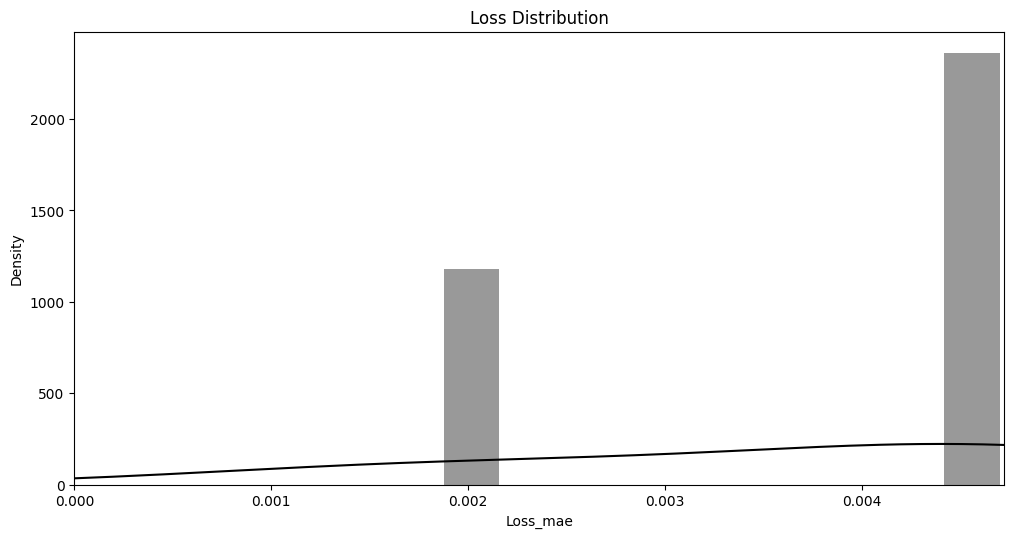

In [ ]:
plt.figure(figsize=(12,6), dpi=100)
plt.title('Loss Distribution', fontsize=12)
sns.distplot(scored['Loss_mae'], bins = 10, kde= True, color = 'black');
plt.xlim([0,scored['Loss_mae'].max()*1.005])

In [ ]:
# A partir da distribuição de perda acima, podemos definir o valor limite para sinalizar anomalia como sendo
# o valor máximo de Loss_mae:
scored['Loss_mae'].max()

0.004700624147376931

In [ ]:
# Cálculo da perda (loss) no conjunto de dados de teste usando o valor limite definido anteriormente:
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred)

In [ ]:
scored = pd.DataFrame()
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = scored['Loss_mae'].max()
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.006701,0.014166,False
1,0.004634,0.014166,False
2,0.000378,0.014166,False
3,0.003811,0.014166,False
4,0.005524,0.014166,False


In [ ]:
# Calcular as mesmas métricas para os dados de treino e colocar todos os dados em um único dataframe para plotagem
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train)
scored_train = pd.DataFrame()
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = scored['Loss_mae'].max()
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])
scored.head()

,Loss_mae,Threshold,Anomaly
0,0.004701,0.014166,False
1,0.004442,0.014166,False
2,0.001875,0.014166,False
3,0.004404,0.014166,False
4,0.006458,0.014166,False


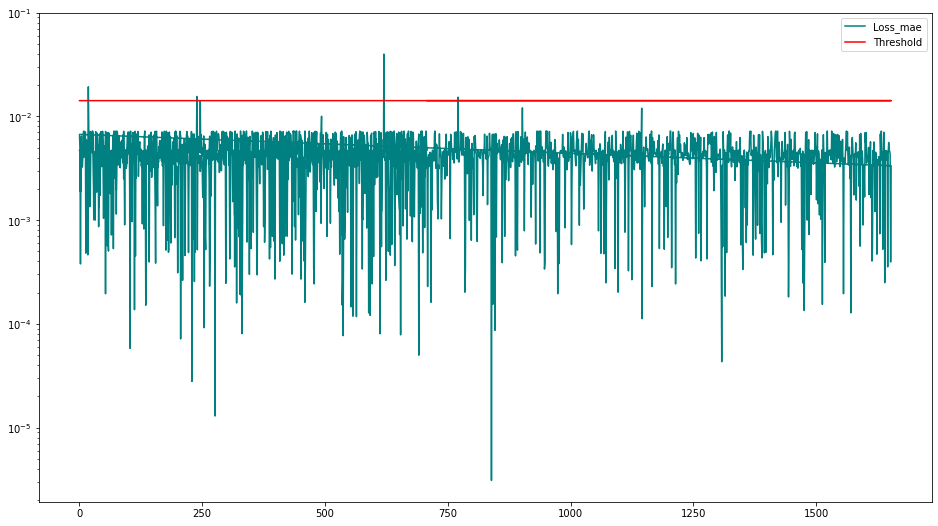

In [ ]:
# Plotar as falhas ao longo do tempo
scored.plot(logy=True,  figsize=(16,9), ylim=[0,1e-1], color=['teal','red'])

In [ ]:
# Salvar o modelo
model.save("Sensor_anomaly_detection.h5")
print("Model saved")

Model saved


## **Conclusões**

O modelo usado foi satisfatório para prever anomalias no sensor testado e a identificação pode ser feita tanto de maneira visual quanto autônoma, sendo que anomalias são classificadas como True quando ultrapassam a linha vermelha que representa o limite máximo daperda (Loss_mae). A análise para o sensor NAH4736 mostrou a existência de 4 anomalias, sendo uma de grande intensidade.

Os dados coletados são suficientes para realizar as análises.